In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv('dataset_sdn.csv')

print(df.head())

print(df.isnull().sum())

print(df.describe())


      dt  switch       src       dst  pktcount  bytecount  dur   dur_nsec  \
0  11425       1  10.0.0.1  10.0.0.8     45304   48294064  100  716000000   
1  11605       1  10.0.0.1  10.0.0.8    126395  134737070  280  734000000   
2  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
3  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   
4  11425       1  10.0.0.2  10.0.0.8     90333   96294978  200  744000000   

        tot_dur  flows  ...  pktrate  Pairflow  Protocol  port_no   tx_bytes  \
0  1.010000e+11      3  ...      451         0       UDP        3  143928631   
1  2.810000e+11      2  ...      451         0       UDP        4       3842   
2  2.010000e+11      3  ...      451         0       UDP        1       3795   
3  2.010000e+11      3  ...      451         0       UDP        2       3688   
4  2.010000e+11      3  ...      451         0       UDP        3       3413   

  rx_bytes  tx_kbps  rx_kbps  tot_kbps  label  
0     39

In [3]:
df.dropna(inplace=True)


In [4]:
df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

df.drop(columns=['src', 'dst'], inplace=True)


In [5]:
X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
class DDoSModel(nn.Module):
    def __init__(self):
        super(DDoSModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

model = DDoSModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')


Epoch 1/50, Loss: 0.21243776695247457
Epoch 2/50, Loss: 0.11236326912011182
Epoch 3/50, Loss: 0.0891972749235445
Epoch 4/50, Loss: 0.07722698263400321
Epoch 5/50, Loss: 0.0714630313937702
Epoch 6/50, Loss: 0.06730097020872297
Epoch 7/50, Loss: 0.0637118121302941
Epoch 8/50, Loss: 0.061960628804498125
Epoch 9/50, Loss: 0.059671658613585726
Epoch 10/50, Loss: 0.05746199171636336
Epoch 11/50, Loss: 0.05629657039876832
Epoch 12/50, Loss: 0.05514417053143268
Epoch 13/50, Loss: 0.05414780607110339
Epoch 14/50, Loss: 0.05278625171896827
Epoch 15/50, Loss: 0.053359445251216886
Epoch 16/50, Loss: 0.05179577104617573
Epoch 17/50, Loss: 0.052129492546495154
Epoch 18/50, Loss: 0.048855994338756835
Epoch 19/50, Loss: 0.05313622866650311
Epoch 20/50, Loss: 0.048456857251925084
Epoch 21/50, Loss: 0.04677322057013869
Epoch 22/50, Loss: 0.04581321029543909
Epoch 23/50, Loss: 0.04802644234993886
Epoch 24/50, Loss: 0.04527025095946243
Epoch 25/50, Loss: 0.04687627403417802
Epoch 26/50, Loss: 0.0460332499

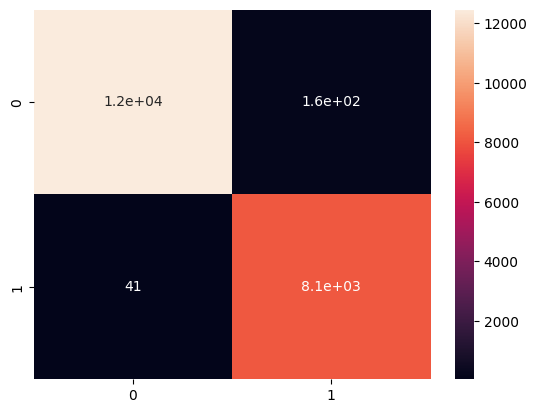

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12613
           1       0.98      0.99      0.99      8155

    accuracy                           0.99     20768
   macro avg       0.99      0.99      0.99     20768
weighted avg       0.99      0.99      0.99     20768



In [9]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).round()
    
   
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

   
    print(classification_report(y_test, y_pred))
